In [ ]:
import os
import cv2
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

# **1. 데이터셋 구성**

In [ ]:
# 데이터 경로 지정하기
data_root = '/content/drive/MyDrive/[수업]컴퓨터비전/실습_DATA/조류 이미지 분류_이전'

In [ ]:
# train.csv 불러오기
df = pd.read_csv(f'{data_root}/train.csv')
df.head()

,img_path,upscale_img_path,label
0,./train/TRAIN_00000.jpg,./upscale_train/TRAIN_00000.png,Ruddy Shelduck
1,./train/TRAIN_00001.jpg,./upscale_train/TRAIN_00001.png,Gray Wagtail
2,./train/TRAIN_00002.jpg,./upscale_train/TRAIN_00002.png,Indian Peacock
3,./train/TRAIN_00003.jpg,./upscale_train/TRAIN_00003.png,Common Kingfisher
4,./train/TRAIN_00004.jpg,./upscale_train/TRAIN_00004.png,Common Kingfisher


In [ ]:
# train.csv에 있는 label값 별로 비중 확인하기
df['label'].value_counts().sort_index(ascending=True)

,count
label,
Asian Green Bee-Eater,613
Brown-Headed Barbet,642
Cattle Egret,641
Common Kingfisher,657
Common Myna,630
Common Rosefinch,653
Common Tailorbird,643
Coppersmith Barbet,550
Forest Wagtail,629


In [ ]:
# train.csv에 있는 label값들을 리스트화 시키기
labels = sorted(df['label'].unique())
labels

['Asian Green Bee-Eater',
 'Brown-Headed Barbet',
 'Cattle Egret',
 'Common Kingfisher',
 'Common Myna',
 'Common Rosefinch',
 'Common Tailorbird',
 'Coppersmith Barbet',
 'Forest Wagtail',
 'Gray Wagtail',
 'Hoopoe',
 'House Crow',
 'Indian Grey Hornbill',
 'Indian Peacock',
 'Indian Pitta',
 'Indian Roller',
 'Jungle Babbler',
 'Northern Lapwing',
 'Red-Wattled Lapwing',
 'Ruddy Shelduck',
 'Rufous Treepie',
 'Sarus Crane',
 'White Wagtail',
 'White-Breasted Kingfisher',
 'White-Breasted Waterhen']

In [ ]:
# label별로 train 하위폴더에 폴더 생성
train_root = f'{data_root}/train'

for label in labels:
  if not os.path.exists(f'{train_root}/{label}'):
    os.makedirs(f'{train_root}/{label}', esist_ok=True)

In [ ]:
# train.csv의 img_path와 label값과 일치하는 폴더로 이미지 이동시키기
for i in range(len(df)):
  img_path = df.loc[i, 'img_path'].replace('./','')
  label = df.loc[i, 'label']
  shutil.move(f'{data_root}/{img_path}', f'{data_root}/train/{label}')

In [ ]:
# 폴더별 이미지개수를 확인하여 기존 train.csv에서 확인한 값과 비교
for label in labels:
  files = os.listdir(f'{data_root}/train/{label}')
  print(f'{label} 이미지 개수: {len(files)}')

Asian Green Bee-Eater 이미지 개수: 491
Brown-Headed Barbet 이미지 개수: 514
Cattle Egret 이미지 개수: 513
Common Kingfisher 이미지 개수: 526
Common Myna 이미지 개수: 504
Common Rosefinch 이미지 개수: 523
Common Tailorbird 이미지 개수: 515
Coppersmith Barbet 이미지 개수: 440
Forest Wagtail 이미지 개수: 504
Gray Wagtail 이미지 개수: 529
Hoopoe 이미지 개수: 505
House Crow 이미지 개수: 504
Indian Grey Hornbill 이미지 개수: 516
Indian Peacock 이미지 개수: 510
Indian Pitta 이미지 개수: 345
Indian Roller 이미지 개수: 512
Jungle Babbler 이미지 개수: 527
Northern Lapwing 이미지 개수: 531
Red-Wattled Lapwing 이미지 개수: 531
Ruddy Shelduck 이미지 개수: 537
Rufous Treepie 이미지 개수: 493
Sarus Crane 이미지 개수: 526
White Wagtail 이미지 개수: 528
White-Breasted Kingfisher 이미지 개수: 533
White-Breasted Waterhen 이미지 개수: 520


<function matplotlib.pyplot.show(close=None, block=None)>

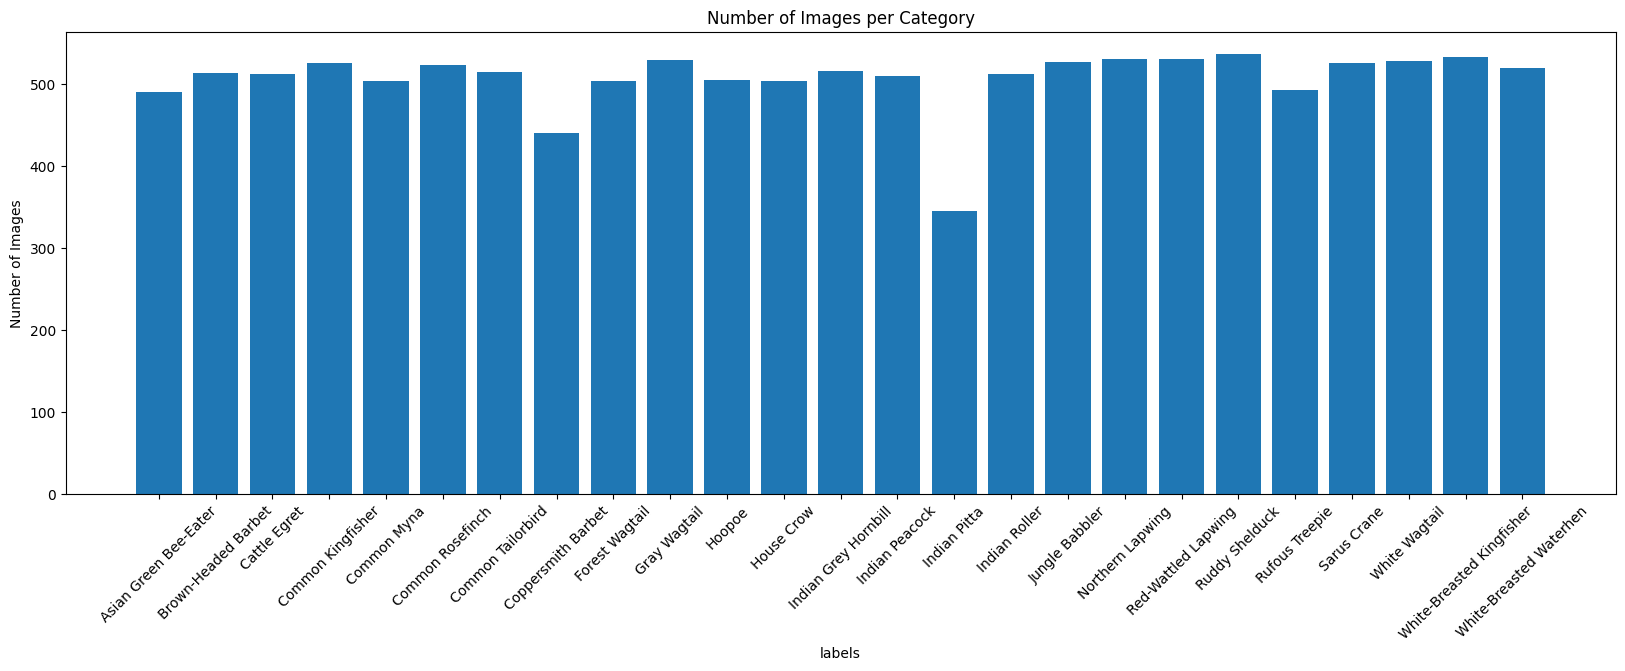

In [ ]:
# label별로 빈도수 시각화 하기
plt.figure(figsize=(20, 6))
plt.bar(labels, [len(os.listdir(f'{data_root}/train/{label}')) for label in labels])
plt.title('Number of Images per Category')
plt.xlabel('labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show

# **2. 데이터셋 분할**

In [ ]:
# val폴더를 새로 생성하고, label별로 하위폴더 생성
val_root = f'{data_root}/val'
if not os.path.exists(val_root):
  os.makedirs(val_root, exist_ok=True)

for label in labels:
  if not os.path.exists(f'{val_root}/{label}'):
    os.makedirs(f'{val_root}/{label}', exist_ok=True)

In [ ]:
# 기존 test폴더에는 label이 없으므로 임의로 자료 삭제 후
# test 폴더를 새로 생성하고, label별로 하위폴더 생성
test_root = f'{data_root}/test'
if not os.path.exists(test_root):
  os.makedirs(test_root, exist_ok=True)

for label in labels:
  if not os.path.exists(f'{test_root}/{label}'):
    os.makedirs(f'{test_root}/{label}', exist_ok=True)

In [ ]:
random.seed(2004)

In [ ]:
for label in labels:
    test_files = os.listdir(f'{test_root}/{label}')

    for file_name in test_files:
        # 파일이 이미 존재하면 이동하지 않음
        if not os.path.exists(f'{train_root}/{label}/{file_name}'):
            shutil.move(f'{test_root}/{label}/{file_name}', f'{train_root}/{label}/{file_name}')


In [ ]:
# 폴더별 이미지개수를 확인하여 기존 train.csv에서 확인한 값과 비교
for label in labels:
  files = os.listdir(f'{data_root}/train/{label}')
  print(f'{label} 이미지 개수: {len(files)}')

Asian Green Bee-Eater 이미지 개수: 613
Brown-Headed Barbet 이미지 개수: 642
Cattle Egret 이미지 개수: 641
Common Kingfisher 이미지 개수: 657
Common Myna 이미지 개수: 630
Common Rosefinch 이미지 개수: 653
Common Tailorbird 이미지 개수: 643
Coppersmith Barbet 이미지 개수: 550
Forest Wagtail 이미지 개수: 629
Gray Wagtail 이미지 개수: 661
Hoopoe 이미지 개수: 631
House Crow 이미지 개수: 630
Indian Grey Hornbill 이미지 개수: 645
Indian Peacock 이미지 개수: 637
Indian Pitta 이미지 개수: 431
Indian Roller 이미지 개수: 639
Jungle Babbler 이미지 개수: 658
Northern Lapwing 이미지 개수: 663
Red-Wattled Lapwing 이미지 개수: 663
Ruddy Shelduck 이미지 개수: 671
Rufous Treepie 이미지 개수: 616
Sarus Crane 이미지 개수: 657
White Wagtail 이미지 개수: 659
White-Breasted Kingfisher 이미지 개수: 666
White-Breasted Waterhen 이미지 개수: 649


In [ ]:
# train에 있는 이미지를 random으로 val, test폴더로 이동시키기(train:val:test→7:1.5:1.5)
random.seed(2004)

for label in labels:
  file_list = os.listdir(f'{train_root}/{label}')
  random.shuffle(file_list)

  ratio = 0.15
  num_file = len(file_list)

  test_list = file_list[:int(num_file*ratio)]
  val_list = file_list[int(num_file*ratio):int(num_file*ratio*2)]
  train_list = file_list[int(num_file*ratio*2):]

  for test_name in test_list:
    shutil.move(f'{train_root}/{label}/{test_name}', f'{test_root}/{label}/{test_name}')

  for val_name in val_list:
    shutil.move(f'{train_root}/{label}/{val_name}', f'{val_root}/{label}/{val_name}')

In [ ]:
# label별로 train, val, test의 개수 및 비율 출력해보기
for label in labels:
  train_files = os.listdir(f'{train_root}/{label}')
  val_files = os.listdir(f'{val_root}/{label}')
  test_files = os.listdir(f'{test_root}/{label}')
  print(f'{label}  train:{len(train_files)}, val:{len(val_files)}, test:{len(test_files)}, ',
        f'train_ratio:{len(train_files)/ (len(val_files)+len(train_files)+len(test_files))*100:.2f}%, ',
        f'val_ratio:{len(val_files)/ (len(val_files)+len(train_files)+len(test_files))*100:.2f}%, ',
        f'test_ratio:{len(test_files)/ (len(val_files)+len(train_files)+len(test_files))*100:.2f}%')

Asian Green Bee-Eater  train:430, val:92, test:91,  train_ratio:70.15%,  val_ratio:15.01%,  test_ratio:14.85%
Brown-Headed Barbet  train:450, val:96, test:96,  train_ratio:70.09%,  val_ratio:14.95%,  test_ratio:14.95%
Cattle Egret  train:449, val:96, test:96,  train_ratio:70.05%,  val_ratio:14.98%,  test_ratio:14.98%
Common Kingfisher  train:460, val:99, test:98,  train_ratio:70.02%,  val_ratio:15.07%,  test_ratio:14.92%
Common Myna  train:441, val:95, test:94,  train_ratio:70.00%,  val_ratio:15.08%,  test_ratio:14.92%
Common Rosefinch  train:458, val:98, test:97,  train_ratio:70.14%,  val_ratio:15.01%,  test_ratio:14.85%
Common Tailorbird  train:451, val:96, test:96,  train_ratio:70.14%,  val_ratio:14.93%,  test_ratio:14.93%
Coppersmith Barbet  train:385, val:83, test:82,  train_ratio:70.00%,  val_ratio:15.09%,  test_ratio:14.91%
Forest Wagtail  train:441, val:94, test:94,  train_ratio:70.11%,  val_ratio:14.94%,  test_ratio:14.94%
Gray Wagtail  train:463, val:99, test:99,  train_ratio

# **이미지 전처리**

(64, 64)


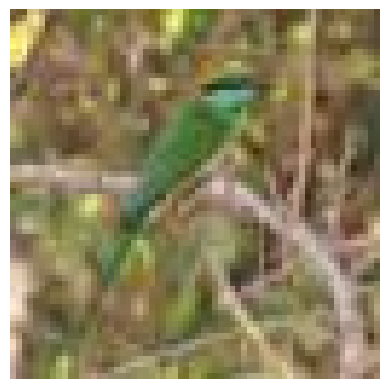

In [ ]:
# 이미지 열기
img = Image.open(f'{data_root}/train/Asian Green Bee-Eater/TRAIN_00086.jpg')

print(img.size)

plt.imshow(img)
plt.axis('off')  # 축을 숨김
plt.show()

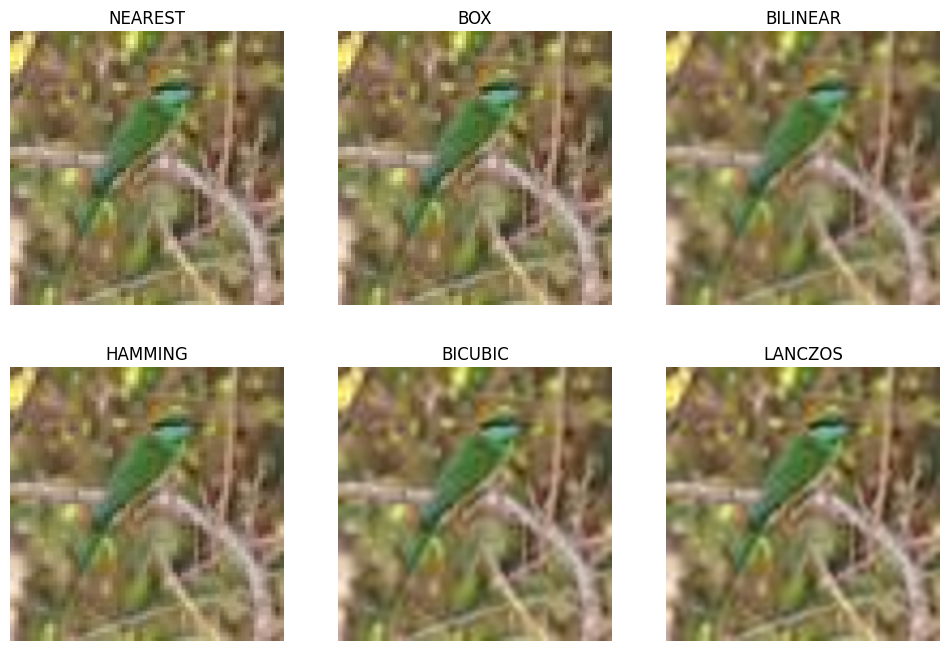

In [ ]:
# 다양한 보간법을 사용하여 리사이즈

names = ['NEAREST', 'BOX', 'BILINEAR', 'HAMMING', 'BICUBIC', 'LANCZOS']
methods = [Image.Resampling.NEAREST, Image.Resampling.BOX, Image.Resampling.BILINEAR,
           Image.Resampling.HAMMING, Image.Resampling.BICUBIC, Image.Resampling.LANCZOS]

plt.figure(figsize=(12, 8))
for idx, (name, method) in enumerate(zip(names, methods)):
  dst = img.resize((400,400), method)
  plt.subplot(2, 3, idx+1)
  plt.imshow(dst)
  plt.title(name)
  plt.axis('off')
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.Resampling.LANCZOS),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = ImageFolder(train_root, transform=transform)
val_dataset = ImageFolder(val_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [ ]:
# AlexNet 모델
model = models.alexnet(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 220MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
# label이 25종류여서 해당 부분 수정
model.classifier[6] = nn.Linear(4096, 25)

# 5, 6부분을 학습에 참여를 시키기로 하여 다음과 같은 코드를 생성
model.classifier[5].requires_grad = True
model.classifier[6].requires_grad = True

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# 모델의 정확도 계산 함수 생성
def calculate_accuracy(loader, model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs =model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
num_epochs = 20

model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss: .6f}, Val Loss: {val_loss: .6f}, Val Accuracy: {val_accuracy: .2f}%')

Epoch 1, Train Loss:  2.015022, Val Loss:  1.571000, Val Accuracy:  56.42%
Epoch 2, Train Loss:  1.493186, Val Loss:  1.390997, Val Accuracy:  60.92%
Epoch 3, Train Loss:  1.357652, Val Loss:  1.304951, Val Accuracy:  62.10%
Epoch 4, Train Loss:  1.261955, Val Loss:  1.254595, Val Accuracy:  64.07%
Epoch 5, Train Loss:  1.203724, Val Loss:  1.216089, Val Accuracy:  64.87%
Epoch 6, Train Loss:  1.152002, Val Loss:  1.188024, Val Accuracy:  65.50%
Epoch 7, Train Loss:  1.113276, Val Loss:  1.165428, Val Accuracy:  66.05%
Epoch 8, Train Loss:  1.081871, Val Loss:  1.163585, Val Accuracy:  66.26%
Epoch 9, Train Loss:  1.057448, Val Loss:  1.143119, Val Accuracy:  66.60%
Epoch 10, Train Loss:  1.023851, Val Loss:  1.131311, Val Accuracy:  66.72%
Epoch 11, Train Loss:  1.002804, Val Loss:  1.124411, Val Accuracy:  66.93%
Epoch 12, Train Loss:  0.985038, Val Loss:  1.125718, Val Accuracy:  66.81%
Epoch 13, Train Loss:  0.969940, Val Loss:  1.126038, Val Accuracy:  67.06%
Epoch 14, Train Loss:

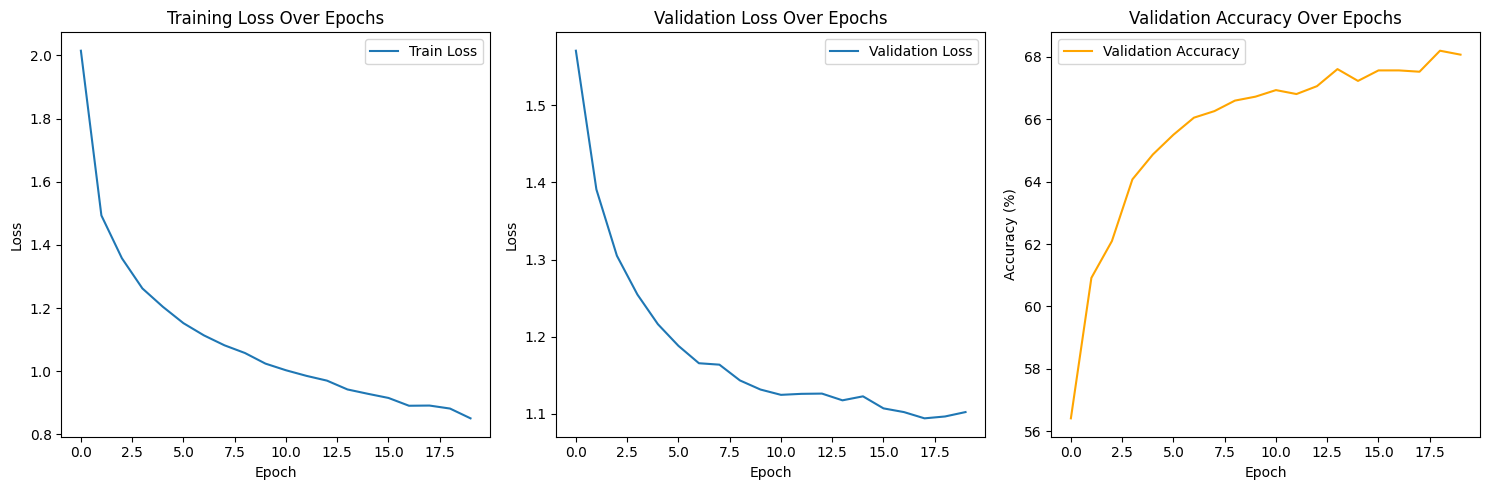

In [ ]:
plt.figure(figsize=(15, 5))
# 학습 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# 검증 손실 그래프
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
# 검증 정확도 그래프
plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

In [ ]:
labels = sorted(df['label'].unique())

In [ ]:
labels

['Asian Green Bee-Eater',
 'Brown-Headed Barbet',
 'Cattle Egret',
 'Common Kingfisher',
 'Common Myna',
 'Common Rosefinch',
 'Common Tailorbird',
 'Coppersmith Barbet',
 'Forest Wagtail',
 'Gray Wagtail',
 'Hoopoe',
 'House Crow',
 'Indian Grey Hornbill',
 'Indian Peacock',
 'Indian Pitta',
 'Indian Roller',
 'Jungle Babbler',
 'Northern Lapwing',
 'Red-Wattled Lapwing',
 'Ruddy Shelduck',
 'Rufous Treepie',
 'Sarus Crane',
 'White Wagtail',
 'White-Breasted Kingfisher',
 'White-Breasted Waterhen']

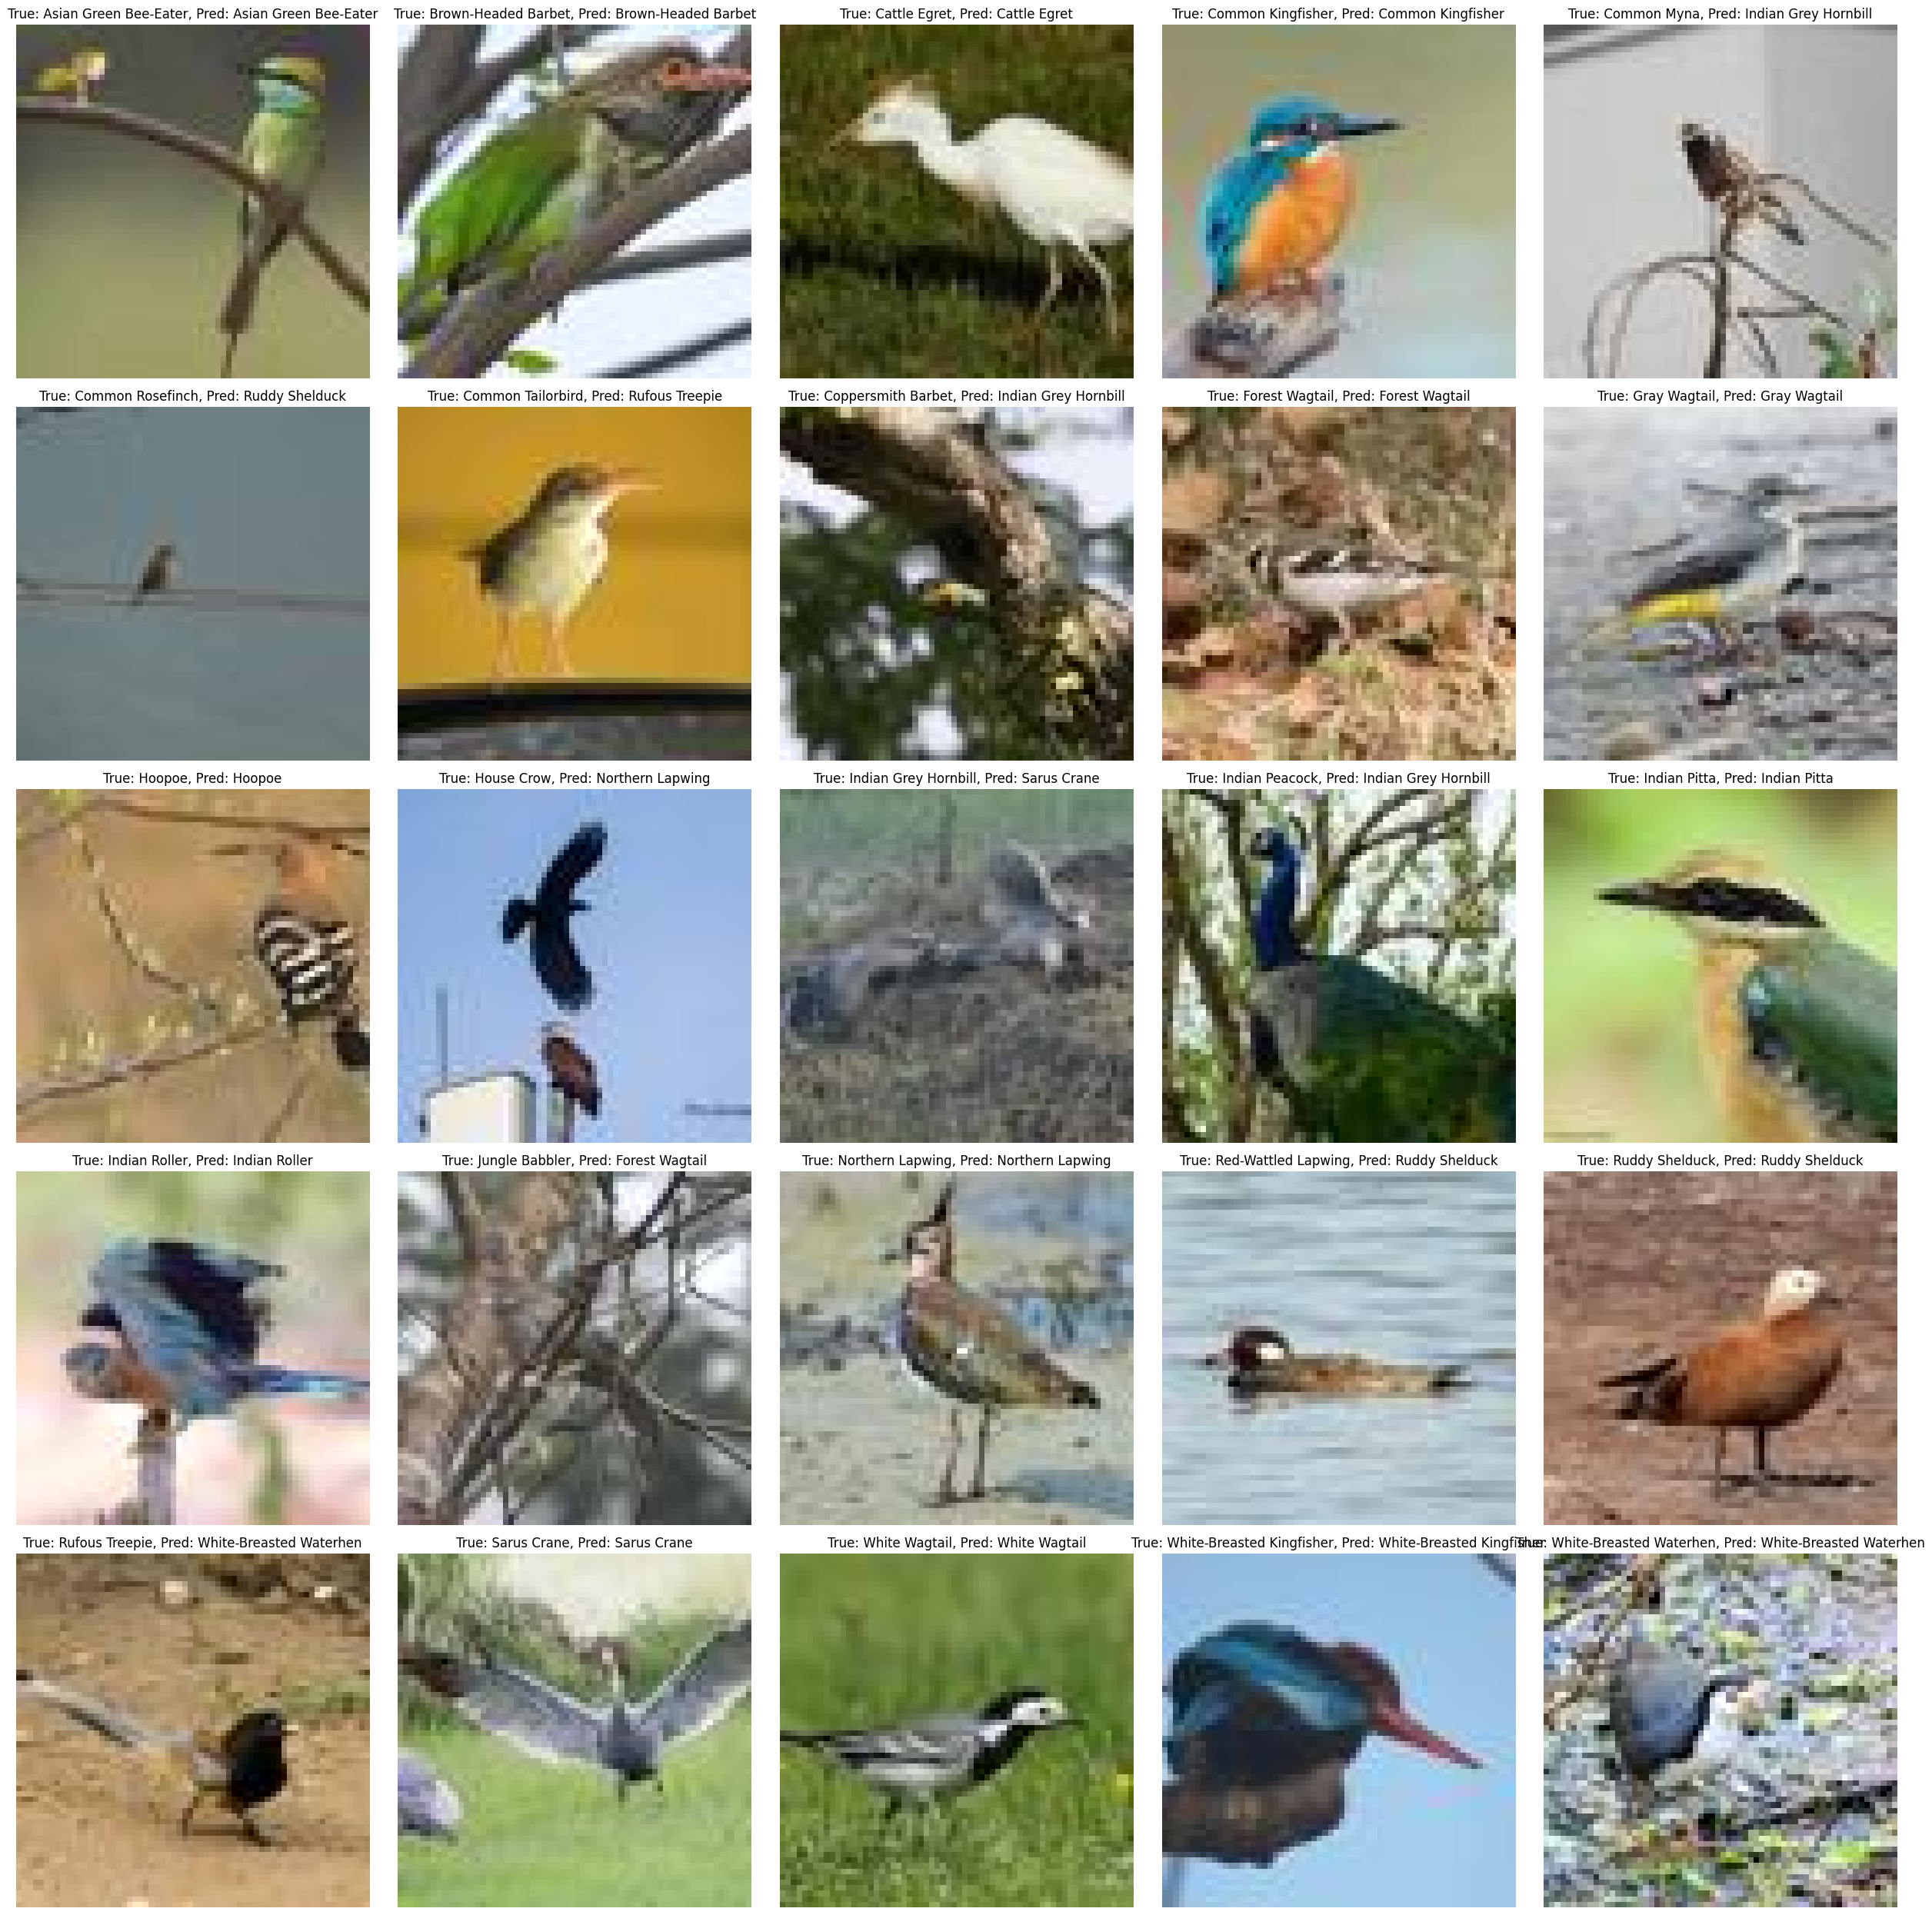

In [ ]:
# test결과 값 시각화
plt.figure(figsize=(25, 25))
counter = 1
for label in labels:
  img_names = os.listdir(f'{data_root}/test/{label}')
  # test파일에 있는 값을 섞은 뒤 첫번째 이미지를 뽑는다
  random.shuffle(img_names)
  selected_img = img_names[0]

  img_path = f'{data_root}/test/{label}/{selected_img}'
  image = load_and_transform_image(img_path, transform)
  image = image.to(device)

  model.eval()
  with torch.no_grad():
      outputs = model(image)
      _, predicted = torch.max(outputs, 1)
  prediction = labels[predicted.item()]
  plt.subplot(5, 5, counter)
  plt.imshow(Image.open(img_path))
  plt.title(f'True: {label}, Pred: {prediction}')
  plt.axis('off')
  counter += 1

plt.tight_layout()
plt.show()